***Mount drive ***

In [26]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


***Install packages ***

In [27]:
pip install tensorflow

***Import Packages ***

In [28]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow.image as tfi
from tensorflow.keras.utils import load_img, img_to_array
from glob import glob
import pandas as pd
import numpy as np
import zipfile
import os
import glob
import random
import sys

import skimage.io                           #Used for imshow function
import skimage.transform                    #Used for resize function
#from skimage.morphology import label        #Used for Run-Length-Encoding RLE to create final submission
import matplotlib.pyplot as plt

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

**Import dataset**

In [32]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

for dirname, _, filenames in os.walk('/content/drive/MyDrive/work-2 CBCT images using GCN and Faster R-CNN/Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/work-2 CBCT images using GCN and Faster R-CNN/Dataset/Img10.PNG
/content/drive/MyDrive/work-2 CBCT images using GCN and Faster R-CNN/Dataset/Img8.PNG
/content/drive/MyDrive/work-2 CBCT images using GCN and Faster R-CNN/Dataset/Img2.png
/content/drive/MyDrive/work-2 CBCT images using GCN and Faster R-CNN/Dataset/Img5.PNG
/content/drive/MyDrive/work-2 CBCT images using GCN and Faster R-CNN/Dataset/Img4.png
/content/drive/MyDrive/work-2 CBCT images using GCN and Faster R-CNN/Dataset/Img9.PNG
/content/drive/MyDrive/work-2 CBCT images using GCN and Faster R-CNN/Dataset/Img3.png
/content/drive/MyDrive/work-2 CBCT images using GCN and Faster R-CNN/Dataset/Img6.PNG
/content/drive/MyDrive/work-2 CBCT images using GCN and Faster R-CNN/Dataset/Img7.PNG
/content/drive/MyDrive/work-2 CBCT images using GCN and Faster R-CNN/Dataset/Img11.PNG
/content/drive/MyDrive/work-2 CBCT images using GCN and Faster R-CNN/Dataset/Img1.png
/content/drive/MyDrive/work-2 CBCT images using GCN 

***Custom IOU metric ***

In [ ]:

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

IMG_WIDTH       = 256
IMG_HEIGHT      = 256
IMG_CHANNELS    = 1

print('Python       :', sys.version.split('\n')[0])
#print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Tensorflow   :', tf.__version__)
#Model hyperparameters
#Next, we define some configurations for UNet++.

# learning rate
LR = 0.001
# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

NUM_EPOCHS=15

**pre processing**

In [ ]:
pip install opencv-python numpy

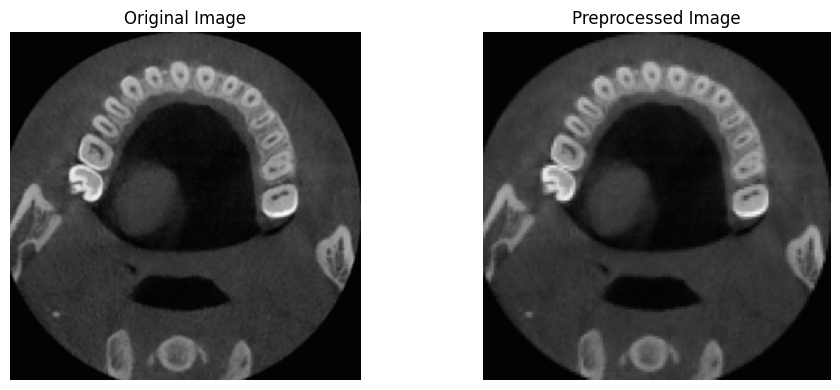

In [33]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Path to your dataset folder
dataset_path = "/content/drive/MyDrive/work-2 CBCT images using GCN and Faster R-CNN/Dataset"

# Target image size
img_size = (128, 128)  # or any size suitable for your model

# Load image file names
image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Pick the first image
img_name = image_files[0]
img_path = os.path.join(dataset_path, img_name)

# Load the original image (BGR format)
img_original = cv2.imread(img_path)
img_original_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

# Resize
img_resized = cv2.resize(img_original, img_size)

# Convert to grayscale
img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

# Normalize pixel values (0 to 1)
img_normalized = img_gray / 255.0

# Display original and preprocessed images
plt.figure(figsize=(10, 4))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img_original_rgb)
plt.title("Original Image")
plt.axis("off")

# Preprocessed image
plt.subplot(1, 2, 2)
plt.imshow(img_normalized, cmap='gray')
plt.title("Preprocessed Image")
plt.axis("off")

plt.tight_layout()
plt.show()


**Data agumentation**

In [35]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator for augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,             # Normalize pixel values between 0 and 1
    rotation_range=40,           # Random rotation (degrees)
    width_shift_range=0.2,       # Horizontal shift
    height_shift_range=0.2,      # Vertical shift
    shear_range=0.2,             # Shearing transformation
    zoom_range=0.2,              # Random zoom
    horizontal_flip=True,        # Flip horizontally
    fill_mode='nearest'          # Fill missing pixels
)

# Example: Apply augmentation to an image
# Load a sample image
img = tf.keras.utils.load_img('/content/drive/MyDrive/work-2 CBCT images using GCN and Faster R-CNN/Dataset/Img25.PNG', target_size=(224, 224))  # Replace with your image path
x = tf.keras.utils.img_to_array(img)  # Convert to numpy array
x = x.reshape((1,) + x.shape)         # Reshape to (1, height, width, channels)

# Generate augmented images and visualize
i = 0
for batch in train_datagen.flow(x, batch_size=1, save_to_dir='/content/drive/MyDrive/work-2 CBCT images using GCN and Faster R-CNN/Dataset'):
    i += 1
    if i > 10:  # Generate 10 augmented images
        break

**Sub-pixel Convolutional Neural Network (SPCNN)**

In [36]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the sub-pixel convolution layer
class SubpixelConv2D(layers.Layer):
    def __init__(self, scale=2, **kwargs):
        super(SubpixelConv2D, self).__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.scale)

    def get_config(self):
        config = super(SubpixelConv2D, self).get_config()
        config.update({"scale": self.scale})
        return config

# Build the Sub-pixel Convolutional Neural Network
def build_srcnn(input_shape=(24, 24, 3), scale=2):
    inputs = layers.Input(shape=input_shape)

    # Feature extraction layers
    x = layers.Conv2D(64, (5, 5), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)

    # Sub-pixel convolution
    x = layers.Conv2D(3 * (scale ** 2), (3, 3), padding='same')(x)
    x = SubpixelConv2D(scale=scale)(x)

    model = models.Model(inputs, x)
    return model

# Create the model
model = build_srcnn()
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='mse')

# The model is now ready to be trained with training data.

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 24, 24, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 12)     │         3,468 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subpixel_conv2d_1               │ (None, 48, 48, 3)      │             0 │
│ (SubpixelConv2D)                │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,724 (248.92 KB)

 Trainable params: 63,724 (248.92 KB)

 Non-trainable params: 0 (0.00 B)

**Graph Convolutional Network (GCN)**

In [56]:
!pip install torch_geometric

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import networkx as nx
import numpy as np

class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / np.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

Epoch 1, Loss: 0.46298155188560486
Epoch 2, Loss: 0.4171096980571747
Epoch 3, Loss: 0.379645437002182
Epoch 4, Loss: 0.35228395462036133
Epoch 5, Loss: 0.31701794266700745
Epoch 6, Loss: 0.2914818525314331
Epoch 7, Loss: 0.27283239364624023
Epoch 8, Loss: 0.24394074082374573
Epoch 9, Loss: 0.23048655688762665
Epoch 10, Loss: 0.20638109743595123
Epoch 11, Loss: 0.19280293583869934
Epoch 12, Loss: 0.17471155524253845
Epoch 13, Loss: 0.15751811861991882
Epoch 14, Loss: 0.13815946877002716
Epoch 15, Loss: 0.13798794150352478
Epoch 16, Loss: 0.12054283916950226
Epoch 17, Loss: 0.10899332910776138
Epoch 18, Loss: 0.10353246331214905
Epoch 19, Loss: 0.0917939841747284
Epoch 20, Loss: 0.08245130628347397
Epoch 21, Loss: 0.07827136665582657
Epoch 22, Loss: 0.06948446482419968
Epoch 23, Loss: 0.06292135268449783
Epoch 24, Loss: 0.06148320809006691
Epoch 25, Loss: 0.05291345715522766
Epoch 26, Loss: 0.04574025049805641
Epoch 27, Loss: 0.0459921695291996
Epoch 28, Loss: 0.04084871709346771
Epoch 2

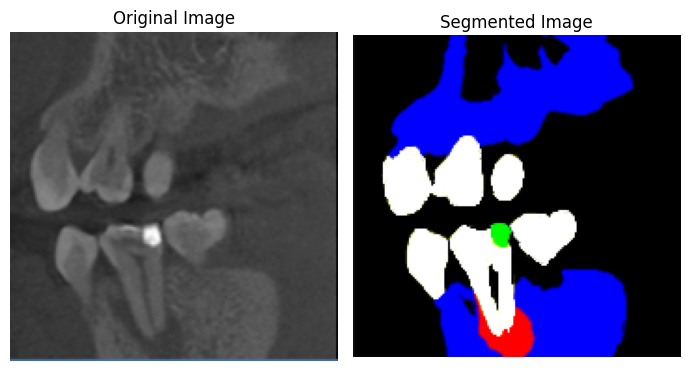

In [58]:
def image_to_graph(image):
    """Convert an image into a graph where each pixel is a node."""
    h, w = image.shape[:2]
    G = nx.grid_2d_graph(h, w)

    # Convert pixel indices to node indices
    mapping = {(i, j): i * w + j for i in range(h) for j in range(w)}
    G = nx.relabel_nodes(G, mapping)

    # Add pixel intensity as node features
    for i in range(h):
        for j in range(w):
            G.nodes[mapping[(i, j)]]['feature'] = image[i, j]

    return G

def adjacency_matrix(graph):
    """Compute the normalized adjacency matrix for the graph."""
    adj = nx.adjacency_matrix(graph).astype(float)
    adj += np.eye(adj.shape[0])  # Add self-loops
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = np.diag(d_inv_sqrt)
    return torch.FloatTensor(adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt))

def feature_matrix(graph):
    """Extract feature matrix from the graph."""
    features = np.array([graph.nodes[i]['feature'] for i in range(graph.number_of_nodes())])
    return torch.FloatTensor(features).unsqueeze(1) # Add a dimension to make it a matrix

# Sample image (for demonstration purposes)
image = np.random.rand(28, 28)  # Replace with actual image data

# Create graph and adjacency matrix
G = image_to_graph(image)
adj = adjacency_matrix(G)
features = feature_matrix(G)

# Define GCN model and optimizer
model = GCN(nfeat=1, nhid=16, nclass=2, dropout=0.5)  # Adjust nclass according to your number of segments
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop (simplified)
model.train()
for epoch in range(50):
    optimizer.zero_grad()
    output = model(features, adj)
    loss = F.nll_loss(output, torch.LongTensor([0] * features.shape[0]))  # Replace with actual labels
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')
import matplotlib.pyplot as plt
import cv2

# Load original and segmented images
original_img_path = '/content/drive/MyDrive/work-2 CBCT images using GCN and Faster R-CNN/Dataset/segment/img1.png'
segmented_img_path = '/content/drive/MyDrive/work-2 CBCT images using GCN and Faster R-CNN/Dataset/segment/img1seg.png'

original_img = cv2.imread(original_img_path)
segmented_img = cv2.imread(segmented_img_path)

# Convert from BGR to RGB for correct display in matplotlib
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
segmented_img_rgb = cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB)

# Display the original and segmented images side by side
plt.figure(figsize=(7, 7))

plt.subplot(1, 2, 1)
plt.imshow(original_img_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmented_img_rgb)
plt.title("Segmented Image")
plt.axis("off")

plt.tight_layout()
plt.show()


**Feature extraction with Grey Level Co-occurrence Matrix (GLCM)**

In [59]:
import numpy as np
import skimage.feature as feature

def calculate_glcm_features(image, distances, angles, levels=256, symmetric=True, normed=True):
    """
    Calculate GLCM and extract features from it.

    :param image: Input image (grayscale)
    :param distances: List of pixel pair distance offsets
    :param angles: List of pixel pair angles in radians
    :param levels: The number of grey levels counted (default 256)
    :param symmetric: If True, the GLCM is symmetric (default True)
    :param normed: If True, normalize the GLCM (default True)
    :return: Dictionary containing GLCM features
    """
    # Use graycomatrix (with 'a') instead of greycomatrix
    glcm = feature.graycomatrix(image,
                                distances=distances,
                                angles=angles,
                                levels=levels,
                                symmetric=symmetric,
                                normed=normed)

    # Extracting features
    features = {
        'contrast': feature.graycoprops(glcm, 'contrast').flatten(),
        'dissimilarity': feature.graycoprops(glcm, 'dissimilarity').flatten(),
        'homogeneity': feature.graycoprops(glcm, 'homogeneity').flatten(),
        'energy': feature.graycoprops(glcm, 'energy').flatten(),
        'correlation': feature.graycoprops(glcm, 'correlation').flatten(),
        'ASM': feature.graycoprops(glcm, 'ASM').flatten()
    }

    return features

# Generate a synthetic image (e.g., random grayscale image)
np.random.seed(0)
image = np.random.randint(0, 256, (8, 8), dtype=np.uint8)  # 8x8 random grayscale image

# Define GLCM parameters
distances = [1, 2, 3]  # Pixel pair distance offsets
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Angles in radians

# Calculate GLCM features
glcm_features = calculate_glcm_features(image, distances, angles)

# Print the extracted features
for feature_name, values in glcm_features.items():
    print(f'{feature_name}: {values}')

contrast: [8081.         9233.16326531 7582.625      7089.87755102 8842.6875
 9233.16326531 8051.5        7089.87755102 9206.45       8399.25
 6850.05       7096.66666667]
dissimilarity: [70.57142857 79.97959184 72.83928571 69.79591837 78.85416667 79.97959184
 72.375      69.79591837 80.55       77.19444444 66.         68.88888889]
homogeneity: [0.00704859 0.00723396 0.00474505 0.00226984 0.00175616 0.00723396
 0.03321301 0.00226984 0.02744452 0.01645396 0.02469101 0.00945488]
energy: [0.09449112 0.10101525 0.09616366 0.10101525 0.10206207 0.10101525
 0.10311974 0.10101525 0.11319231 0.11785113 0.1118034  0.11785113]
correlation: [ 0.08206857 -0.04475219  0.16575735  0.17609041  0.01080648 -0.04475219
  0.07927385  0.17609041 -0.02737601  0.01431675  0.20900469  0.15847154]
ASM: [0.00892857 0.01020408 0.00924745 0.01020408 0.01041667 0.01020408
 0.01063368 0.01020408 0.0128125  0.01388889 0.0125     0.01388889]


***Faster R-CNN for detection ***

In [60]:
pip install torch torchvision

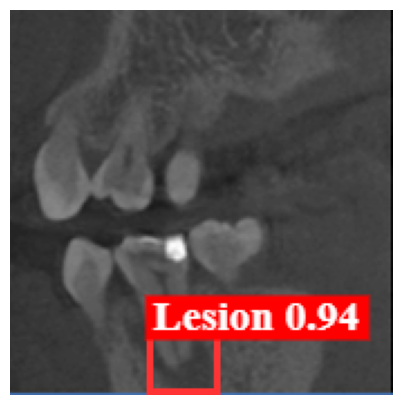

In [50]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load a pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Helper function to visualize the detections
def visualize_detections(image, boxes, labels, scores, threshold=0.5):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    ax = plt.gca()

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin, f'{label} {score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5), clip_box=ax.clipbox, clip_on=True)

    plt.axis('off')
    plt.show()

# Load and preprocess an image
image_path = "/content/drive/MyDrive/work-2 CBCT images using GCN and Faster R-CNN/Dataset/segment/img1det.png"  # Replace with your image path
image = Image.open(image_path).convert("RGB")
image_tensor = F.to_tensor(image)  # Convert the image to a PyTorch tensor

# Perform detection
with torch.no_grad():
    predictions = model([image_tensor])

# Extract predictions
pred_boxes = predictions[0]['boxes'].cpu().numpy()
pred_labels = predictions[0]['labels'].cpu().numpy()
pred_scores = predictions[0]['scores'].cpu().numpy()

# Visualize the detections
visualize_detections(image, pred_boxes, pred_labels, pred_scores, threshold=0.5)

In [51]:
import numpy as np
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import matthews_corrcoef
import seaborn as sn
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X.reshape((train_X.shape[0], 28, 28, 1)).astype('float32') / 255
test_X = test_X.reshape((test_X.shape[0], 28, 28, 1)).astype('float32') / 255
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_X, train_y, epochs=3, batch_size=200, validation_split=0.2, verbose=2)
y_pred = model.predict(test_X)
y_pred_classes = y_pred.argmax(axis=1)
y_test_classes = test_y.argmax(axis=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
240/240 - 31s - 129ms/step - accuracy: 0.9179 - loss: 0.3016 - val_accuracy: 0.9665 - val_loss: 0.1171
Epoch 2/3
240/240 - 24s - 98ms/step - accuracy: 0.9742 - loss: 0.0876 - val_accuracy: 0.9768 - val_loss: 0.0792
Epoch 3/3
240/240 - 26s - 108ms/step - accuracy: 0.9830 - loss: 0.0588 - val_accuracy: 0.9818 - val_loss: 0.0609
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [53]:
precision = precision_score(y_test_classes, y_pred_classes, average='macro')
recall = recall_score(y_test_classes, y_pred_classes, average='macro')
f1 = f1_score(y_test_classes, y_pred_classes, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9813
Recall: 0.9812
F1 Score: 0.9812
